<a href="https://colab.research.google.com/github/sperezdd/TFG/blob/master/TFG_Sandra_P%C3%A9rez_Dominguez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Montar** sobre un drive


In [1]:
 # Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Change to assignment directory ('TDImagen_Practicas/P9_P10' by default)
import os
os.chdir('/content/drive/My Drive/TFG')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Librerias** necesarias para la realizacion del proyecto

In [5]:
import numpy  as np
import matplotlib.pyplot as plt # Importa la librería matplotlib
import cv2 #Importa la librería opencv
import csv
import glob

%tensorflow_version 2.1
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten,Dropout,Input, BatchNormalization,GlobalAveragePooling2D, Concatenate, UpSampling2D,Add, Multiply
from tensorflow.keras.activations import relu,sigmoid
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image as preprocessing_image
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras import utils 
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.metrics import AUC
import tensorflow as tf
from keras import backend as K

from sklearn.metrics import roc_auc_score,roc_curve,average_precision_score,auc, precision_score
import skimage.transform as st
import shutil
import pandas as pd

plt.style.use('default')

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.1`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


Using TensorFlow backend.


**Cargamos** los path 


In [6]:

dirname = os.path.join(os.getcwd(),'imagenes_y_etiquetas/part_3')
json_dirname = os.path.join(os.getcwd(),'imagenes_y_etiquetas/part_2')

dataset_path = dirname + os.sep 
print("Cargando dateset de: ",dataset_path)

train_path = dataset_path + 'train' + os.sep
print("train path: ", train_path)

val_path = dataset_path + 'validation' + os.sep
print("validation path: ", val_path)

test_path = dataset_path + 'test' + os.sep
print("Test path: ", test_path)

categories = ["melanoma", "seborrheic_keratosis","nevus"]
print("La clasificacion se hara sobre las siguientes categorias: " + categories[0] + ", " + categories[1] + "," + categories[2])

train_groundTruth_path = train_path + 'ISIC-2017_Training_Part3_GroundTruth.csv'
print("Las etiquetas de entrenamiento estan en: ", train_groundTruth_path)

val_groundTruth_path = val_path + 'ISIC-2017_Validation_Part3_GroundTruth.csv'
print("Las etiquetas de validacion estan en: ", val_groundTruth_path)

test_groundTruth_path = test_path + 'ISIC-2017_Test_v2_Part3_GroundTruth.csv'
print("Las etiquetas de test estan en: ", test_groundTruth_path)

x_val_original = [] + sorted(glob.glob(val_path + 'ISIC-2017_Validation_Data' + '/*.jpg'))
x_val_original_superpixels = [] + sorted(glob.glob(val_path + 'ISIC-2017_Validation_Data' + '/*.png'))

#cojo solo los .jpg de las imagenes de test. Tambien habia metadata.
x_test_original = [] + sorted(glob.glob(test_path +'ISIC-2017_Test_v2_Data' + '/*.jpg')) 
x_test_original_superpixels = [] + sorted(glob.glob(test_path + 'ISIC-2017_Test_v2_Data' + '/*.png'))
json_test_path = [] + sorted(glob.glob(json_dirname + os.sep + 'test' + os.sep + 'ISIC-2017_Test_v2_Part2_GroundTruth' + '/*.json'))

#cojo solo los .jpg de las imagenes de validation. Tambien habia metadata.
x_train_original = [] + sorted(glob.glob(train_path + 'ISIC-2017_Training_Data' + '/*.jpg'))
x_train_original_superpixels = [] + sorted(glob.glob(train_path + 'ISIC-2017_Training_Data' + '/*.png'))


Cargando dateset de:  /content/drive/My Drive/TFG/imagenes_y_etiquetas/part_3/
train path:  /content/drive/My Drive/TFG/imagenes_y_etiquetas/part_3/train/
validation path:  /content/drive/My Drive/TFG/imagenes_y_etiquetas/part_3/validation/
Test path:  /content/drive/My Drive/TFG/imagenes_y_etiquetas/part_3/test/
La clasificacion se hara sobre las siguientes categorias: melanoma, seborrheic_keratosis,nevus
Las etiquetas de entrenamiento estan en:  /content/drive/My Drive/TFG/imagenes_y_etiquetas/part_3/train/ISIC-2017_Training_Part3_GroundTruth.csv
Las etiquetas de validacion estan en:  /content/drive/My Drive/TFG/imagenes_y_etiquetas/part_3/validation/ISIC-2017_Validation_Part3_GroundTruth.csv
Las etiquetas de test estan en:  /content/drive/My Drive/TFG/imagenes_y_etiquetas/part_3/test/ISIC-2017_Test_v2_Part3_GroundTruth.csv


# FUNCIONES


In [7]:
##Funciones para guardar las mascaras de estructuras y los mapas de atención

def saveInFolderSuperpixels(path_mask, y_label, mask):
  set = path_mask.split("/")[7]
  name = path_mask.split("/")[9]
  if(y_label == 0):
    category = "nevus"
  else:
    category = "melanoma"
  path = os.path.join(os.getcwd(),'imagenes_y_etiquetas') + os.sep + "superpixels" + os.sep + set + os.sep + category + os.sep + name
  print(path)
  print("guardadaaaaa")
  preprocessing_image.save_img(path, preprocessing_image.array_to_img(mask), data_format=None, file_format=None)
 # newPath = shutil.copy(path_image, path)
  return 

def saveMap(map, path, image_,y_label):
   set = path.split("/")[7]
   name = path.split("/")[9]
   if(y_label == 0):
     category = "nevus"
   else:
     category = "melanoma"
   path = os.path.join(os.getcwd(),'imagenes_y_etiquetas') + os.sep +"attention" + os.sep + set + os.sep  + category + os.sep + map + os.sep + name
   print(image_.shape)
   preprocessing_image.save_img(path, image_, data_format=None, file_format=None)
   return


In [8]:
#Funcion para el preprocesado de las imagenes de entrenamiento. Recorta la imagenes 0.8*max(height,weight) sobre el centro de la imagen
def crop(img):
  high = img.shape[0]
  weight = img.shape[1]
  lado = round(0.8*min(high,weight))
  y1 = round((high-lado)/2)
  y2 = high - y1
  x1= round((weight-lado)/2)
  x2 = weight - x1
  image_croped = img[y1:y2,x1:x2]
  return preprocessing_image.img_to_array(image_croped)

#Funcion que normaliza la imagen
def normalized(img, mean_r,mean_g,mean_b):
  img_r = np.asarray(img[:,:,0]).astype(float) - mean_r
  img_g = np.asarray(img[:,:,1]).astype(float) - mean_g
  img_b = np.asarray(img[:,:,2]).astype(float) - mean_b
  image = np.asarray(img).astype(float)
  image[:,:,0] = img_r
  image[:,:,1] = img_g
  image[:,:,2] = img_b
  return image


#DATA GENERATOR


Found 1746 images belonging to 2 classes.
Found 108 images belonging to 2 classes.
Found 510 images belonging to 2 classes.
['a-nevus/ISIC_0000000.jpg', 'a-nevus/ISIC_0000001.jpg', 'a-nevus/ISIC_0000003.jpg', 'a-nevus/ISIC_0000006.jpg', 'a-nevus/ISIC_0000007.jpg', 'a-nevus/ISIC_0000008.jpg', 'a-nevus/ISIC_0000009.jpg', 'a-nevus/ISIC_0000010.jpg', 'a-nevus/ISIC_0000011.jpg', 'a-nevus/ISIC_0000012.jpg', 'a-nevus/ISIC_0000014.jpg', 'a-nevus/ISIC_0000015.jpg', 'a-nevus/ISIC_0000016.jpg', 'a-nevus/ISIC_0000017.jpg', 'a-nevus/ISIC_0000018.jpg', 'a-nevus/ISIC_0000019.jpg', 'a-nevus/ISIC_0000020.jpg', 'a-nevus/ISIC_0000021.jpg', 'a-nevus/ISIC_0000023.jpg', 'a-nevus/ISIC_0000024.jpg', 'a-nevus/ISIC_0000025.jpg', 'a-nevus/ISIC_0000027.jpg', 'a-nevus/ISIC_0000028.jpg', 'a-nevus/ISIC_0000032.jpg', 'a-nevus/ISIC_0000034.jpg', 'a-nevus/ISIC_0000037.jpg', 'a-nevus/ISIC_0000038.jpg', 'a-nevus/ISIC_0000039.jpg', 'a-nevus/ISIC_0000041.jpg', 'a-nevus/ISIC_0000042.jpg', 'a-nevus/ISIC_0000044.jpg', 'a-nevu

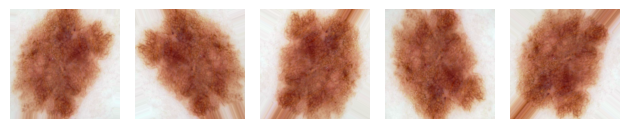

In [9]:
# DATA GENERATOR

def preprocessed_input(image):
  img = st.resize(image, (224, 224))
  img_normalized = normalized(img,123.68,116.779,103.939)
  return img_normalized
  
train_datagen = preprocessing_image.ImageDataGenerator(rescale = None,horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=90,
                                   preprocessing_function = preprocessed_input)


datagen = preprocessing_image.ImageDataGenerator(preprocessing_function = preprocessed_input)

train_path = os.path.join(os.getcwd(),'imagenes_y_etiquetas') + os.sep + "recortadas" + os.sep + "train"

validation_path = os.path.join(os.getcwd(),'imagenes_y_etiquetas') + os.sep + "recortadas" + os.sep + "validation"

test_path = os.path.join(os.getcwd(),'imagenes_y_etiquetas') + os.sep + "recortadas" + os.sep + "test"

train_generator = train_datagen.flow_from_directory(
        train_path,
        color_mode='rgb',
        batch_size=32,
        target_size=[224,224],
        class_mode='binary',
        shuffle=True,
        seed=42)

validation_generator = datagen.flow_from_directory(
        validation_path,
        color_mode='rgb',
        batch_size=32,
        target_size=[224,224],
        class_mode='binary',
        shuffle=True,
        seed=42)

test_generator = datagen.flow_from_directory(
        test_path,
        target_size=[224,224],
        color_mode='rgb',
        class_mode='binary',
        shuffle=False,
        batch_size = 1,
        seed=42)
print(train_generator.filenames)

#Imprime una imagen 5 veces aplicando data augmentation
augmented_images = [train_generator[2][0][0] for i in range(5)]
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5)
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(preprocessing_image.array_to_img(img))
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(augmented_images)


STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VAL=validation_generator.n//validation_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

#PESOS

In [10]:
#PESOS 

#Calculo de los pesos para el desbalanceo de clases
melanoma_weight = 374/1746
nevus_weight = 1372/1746
class_weight = {1: nevus_weight,
                0: melanoma_weight}

#Descarga pesos ImageNet
WEIGHTS_PATH = ('https://github.com/fchollet/deep-learning-models/'
'releases/download/v0.1/'
'vgg16_weights_tf_dim_ordering_tf_kernels.h5')

Imagenet_weights = utils.get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',WEIGHTS_PATH,cache_subdir='models',file_hash='64373286793e3c8b2b4e3219cbf3544b')


553467904/553467096 [==============================] - 36s 0us/step


#**MODELOS**
---




# METRICS
---





In [11]:
#Funciones
def obtainFnFpTnTp(y_true,y_pred):
    y_pred = K.round(K.clip(y_pred, 0, 1))
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tp = K.sum(y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    fn = K.sum( y_true * neg_y_pred)
    return fp,tp,fn,tn
    
def precision(y_true, y_pred):
  fp,tp,fn,tn = obtainFnFpTnTp(y_true,y_pred)
  precision = tp/(tp+fp + K.epsilon())
  return precision

def sensibilidad(y_true, y_pred):
  fp,tp,fn,tn = obtainFnFpTnTp(y_true,y_pred)
  sensibilidad = tp/(tp+fn + K.epsilon())
  return sensibilidad

def especifidad(y_true,y_pred):
  print(y_true)
  print(y_pred)
  fp,tp,fn,tn = obtainFnFpTnTp(y_true,y_pred)
  especifidad = tn/(tn + fp + K.epsilon())
  return especifidad

def aucs(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    return auc

def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc

# MODELO VGG-16 + módulos de atención



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_bn1 (BatchNormalization) (None, 224, 224, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_act1 (Activation)        (None, 224, 224, 64) 0           block1_bn1[0][0]                 
______________________________________________________________________________________________

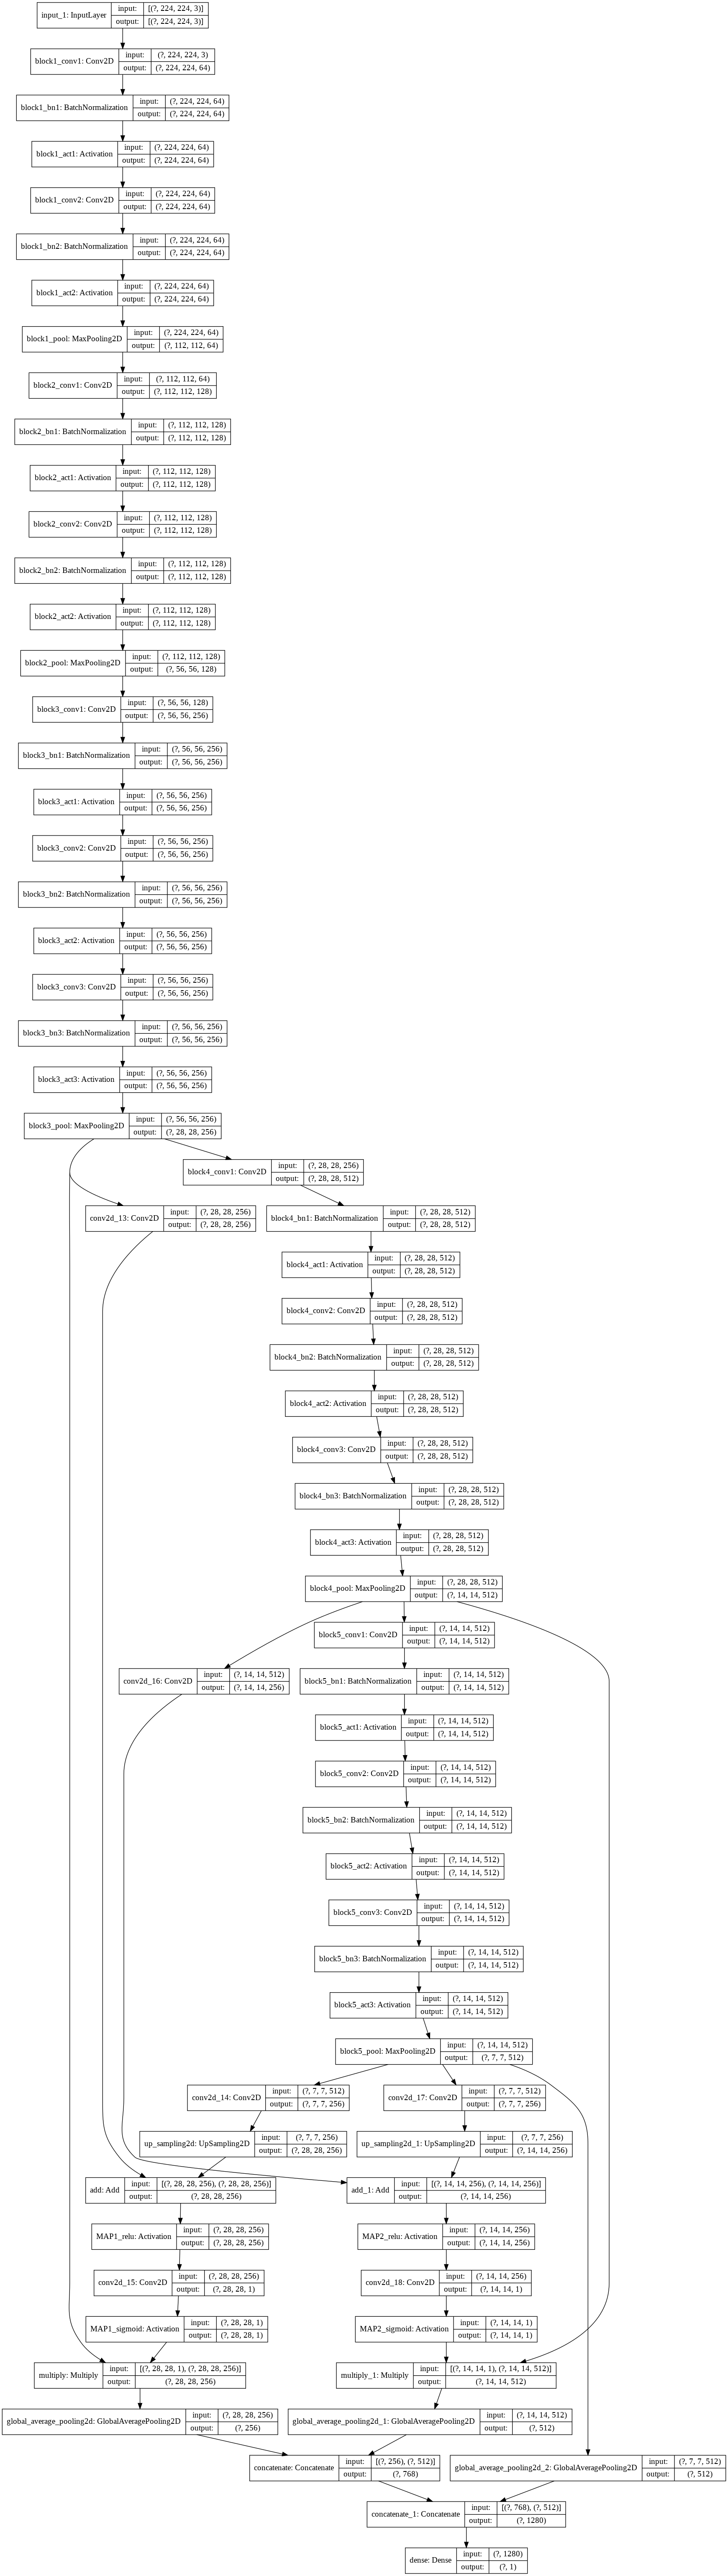

In [12]:
### VGG16 CON LOS MECANISMOS DE ATENCION

tf.random.set_seed(1234)
img_input = Input(shape=[224,224,3], name="input_1")
x = (Conv2D(64,(3,3), padding='same', name="block1_conv1")) (img_input)
x = (BatchNormalization(name='block1_bn1'.format(1, 1)))(x)
x = (Activation('relu', name='block1_act1'.format(1, 1)))(x)

x = (Conv2D(64,(3,3), padding='same', name="block1_conv2"))(x)
x = (BatchNormalization(name='block1_bn2'.format(1, 2)))(x)
x = (Activation('relu', name='block1_act2'.format(1, 2)))(x)


x = (MaxPooling2D((2,2),strides=(2,2), name="block1_pool"))(x)

x= (Conv2D(128,(3,3), padding='same', name="block2_conv1"))(x)
x = (BatchNormalization(name='block2_bn1'.format(2, 1)))(x)
x = (Activation('relu', name='block2_act1'.format(2, 1)))(x)


x= (Conv2D(128,(3,3), padding='same', name="block2_conv2"))(x)
x = (BatchNormalization(name='block2_bn2'.format(2, 2)))(x)
x = (Activation('relu', name='block2_act2'.format(2, 2)))(x)


x = (MaxPooling2D((2,2),strides=(2,2), name="block2_pool"))(x)

x= (Conv2D(256,(3,3), padding='same', name="block3_conv1"))(x)
x = (BatchNormalization(name='block3_bn1'.format(3, 1)))(x)
x = (Activation('relu', name='block3_act1'.format(3, 1)))(x)


x= (Conv2D(256,(3,3), padding='same', name="block3_conv2"))(x)
x = (BatchNormalization(name='block3_bn2'.format(3, 2)))(x)
x = (Activation('relu', name='block3_act2'.format(3, 2)))(x)


x= (Conv2D(256,(3,3), padding='same', name="block3_conv3"))(x)
x = (BatchNormalization(name='block3_bn3'.format(3, 3)))(x)
x = (Activation('relu', name='block3_act3'.format(3, 3)))(x)

pool_3 = (MaxPooling2D((2,2),strides=(2,2), name="block3_pool"))(x)

x= (Conv2D(512,(3,3), padding='same', name="block4_conv1"))(pool_3)
x = (BatchNormalization(name='block4_bn1'.format(4, 1)))(x)
x = (Activation('relu', name='block4_act1'.format(4, 1)))(x)


x= (Conv2D(512,(3,3), padding='same', name="block4_conv2"))(x)
x = (BatchNormalization(name='block4_bn2'.format(4, 2)))(x)
x = (Activation('relu', name='block4_act2'.format(4, 2)))(x)


x = (Conv2D(512,(3,3), padding='same', name="block4_conv3"))(x)
x = (BatchNormalization(name='block4_bn3'.format(4, 3)))(x)
x = (Activation('relu', name='block4_act3'.format(4, 3)))(x)


pool_4 = (MaxPooling2D((2,2),strides=(2,2), name="block4_pool"))(x)

x= (Conv2D(512,(3,3), padding='same', name="block5_conv1"))(pool_4)
x = (BatchNormalization(name='block5_bn1'.format(5, 1)))(x)
x = (Activation('relu', name='block5_act1'.format(5, 1)))(x)

x= (Conv2D(512,(3,3), padding='same', name="block5_conv2"))(x)
x = (BatchNormalization(name='block5_bn2'.format(5, 2)))(x)
x = (Activation('relu', name='block5_act2'.format(5, 2)))(x)


x= (Conv2D(512,(3,3), padding='same',name="block5_conv3"))(x)
x = (BatchNormalization(name='block5_bn3'.format(5,3)))(x)
x = (Activation('relu', name='block5_act3'.format(5, 3)))(x)


pool_5 = (MaxPooling2D((2,2),strides=(2,2), name="block5_pool"))(x)

## MODULOS DE ATENCION

#pool3
wf3 =(Conv2D(256,(3,3), activation = 'relu', padding='same', name="conv2d_13"))(pool_3)
wg3 = (Conv2D(256,(3,3), activation = 'relu', padding='same', name="conv2d_14"))(pool_5)
wg3 = (UpSampling2D(size = 4, name="up_sampling2d" ))(wg3)

added3 = Add(name='add')([wf3, wg3])
Relu3 = (Activation('relu', name='MAP1_relu'.format(1, 1)))(added3)
A3 = (Conv2D(1,(3,3), padding='same', name="conv2d_15"))(Relu3)
A3 = (Activation('sigmoid', name='MAP1_sigmoid'.format(1, 1)))(A3)

multiply3 = Multiply(name='multiply')([A3, pool_3])
attention_1 = multiply3

#pool_4
wf4 =(Conv2D(256,(3,3), activation = 'relu', padding='same', name="conv2d_16"))(pool_4)
wg4 = (Conv2D(256,(3,3), activation = 'relu', padding='same',name="conv2d_17"))(pool_5)
wg4 = (UpSampling2D(size = 2, name="up_sampling2d_1"))(wg4)

added4 = Add(name="add_1")([wf4, wg4])
Relu4 = (Activation('relu', name='MAP2_relu'.format(1, 1)))(added4)
A4 = (Conv2D(1,(3,3), padding='same', name="conv2d_18"))(Relu4)
A4 = (Activation('sigmoid', name='MAP2_sigmoid'.format(1, 1)))(A4)

multiply4 = Multiply(name="multiply_1")([A4, pool_4])
attention_2 = multiply4

GlobalAverageAtention1 = GlobalAveragePooling2D(name="global_average_pooling2d")(attention_1)
GlobalAverageAtention2 = GlobalAveragePooling2D(name="global_average_pooling2d_1")(attention_2)
GlobalAveragePool5 = GlobalAveragePooling2D(name="global_average_pooling2d_2")(pool_5)
Concatenate1 = Concatenate(axis=1, name="concatenate")([GlobalAverageAtention1, GlobalAverageAtention2])
feature_vector = Concatenate(axis=1, name="concatenate_1")([Concatenate1, GlobalAveragePool5])
out = Dense(1, activation = 'sigmoid', name="dense")(feature_vector)

trained_model = Model(inputs = [img_input], outputs = [out])
trained_model.load_weights(Imagenet_weights,by_name=True)
trained_model.summary()
plot_model(trained_model, to_file='model.png',show_shapes=True,show_layer_names=True)


#**ENTRENAMIENTO**

---



In [13]:
# FUNCIONES

# Learning rate variable
def scheduler(epoch,lr):
  if epoch%10 == 0:
    if(epoch==0):
      print("epoca:", epoch)
      print(lr)
      return lr

    print("epoca:", epoch)
    print(lr)
    return lr/10
  else:
    print("epoca:", epoch)
    print(lr)
    return lr

learningRateScheduler = LearningRateScheduler(scheduler)

# Focal_loss
def focal_loss(gamma=2., alpha=.25):
  def focal_loss_fixed(y_true, y_pred):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
  return focal_loss_fixed

# optimizadores
adam = Adam(learning_rate=0.00001, amsgrad=False)

#Earlystopping
earlystopping = EarlyStopping(monitor='val_loss', mode ="min", patience=10)

#checkpoint
checkpoint = ModelCheckpoint('weights/Adam/Focal_loss/Checkpoint.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min', period=1, save_weights_only=True)




#ATTENTION_MODEL



In [ ]:
vgg16Gap.compile(loss=[focal_loss(gamma=2., alpha=.25)], optimizer=adam, metrics=['acc',precision,especifidad,sensibilidad,AUC()])
history = vgg16Gap.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              epochs=50,
                              class_weight=class_weight,
                              validation_data=validation_generator,
                              callbacks=[learningRateScheduler, checkpoint],
                              validation_steps = STEP_SIZE_VAL)
vgg16Gap.save_weights('weights/Adam/Focal_loss/AttnMelCNN-weights.h5')2l


Instructions for updating:
Please use Model.fit, which supports generators.
epoca: 0
9.999999747378752e-06
Epoch 1/50
Tensor("ExpandDims:0", shape=(None, 1), dtype=float32)
Tensor("model_1/dense/Sigmoid:0", shape=(None, 1), dtype=float32)
Tensor("ExpandDims:0", shape=(None, 1), dtype=float32)
Tensor("model_1/dense/Sigmoid:0", shape=(None, 1), dtype=float32)
54/54 [==============================] - ETA: 0s - loss: 0.0503 - acc: 0.6103 - precision: 0.3540 - especifidad: 0.6290 - sensibilidad: 0.5157 - auc: 0.6078  Tensor("ExpandDims:0", shape=(None, 1), dtype=float32)
Tensor("model_1/dense/Sigmoid:0", shape=(None, 1), dtype=float32)

Epoch 00001: val_loss improved from inf to 0.43533, saving model to weights/Adam/Focal_loss/Checkpoint_10.h5
54/54 [==============================] - 3488s 65s/step - loss: 0.0503 - acc: 0.6103 - precision: 0.3540 - especifidad: 0.6290 - sensibilidad: 0.5157 - auc: 0.6078 - val_loss: 0.4353 - val_acc: 0.2500 - val_precision: 0.2500 - val_especifidad: 0.0000e

#**RESULTADOS**

---



#CURVA ROC Y MEDIDAS DE EVALUACION 

Instructions for updating:
Please use Model.predict, which supports generators.
510/510 [==============================] - 506s 992ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

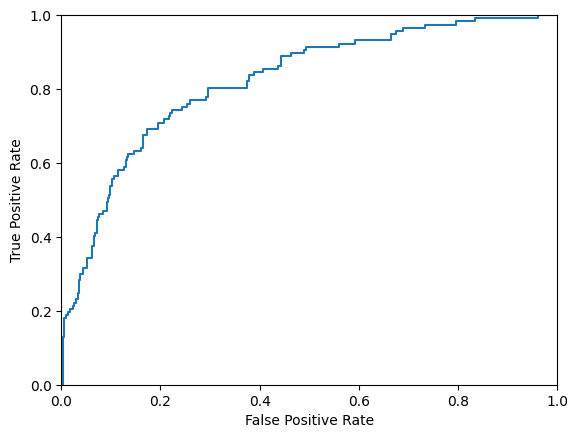

NameError: ignored

In [15]:
## OBTENCION CURVA ROC Y AUC 

trained_model.load_weights("weights/Adam/Focal_loss/definitivos.h5")

test_generator.reset()
pred=trained_model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

# Curva ROC y AUC
fpr,tpr,auc = roc_curve_and_score(test_generator.labels,pred)
auc_test = auc
especifidad_test = especifidad(test_generator.labels, pred)
AP_test = average_precision_score(test_generator.labels, pred)


def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Cálculo del número de aciertos 
aciertos=0
aciertos_verdaderos=0;
for x in range(len(test_generator.labels)):
  if(K.round(pred[x]) == test_generator.labels[x]):
    aciertos = aciertos+1
    if(test_generator.labels[x] == 1):
      aciertos_verdaderos = aciertos_verdaderos+1

print("---------------ESTADISTICAS---------------")
print("Aciertos totales: ",aciertos)
print("De 117 melanomas ha acertado: ", aciertos_verdaderos)
print("De 393 nevus ha acertado: ", aciertos - aciertos_verdaderos)



#MAPAS DE ATENCIÓN

In [16]:
#A partir del modelo recien entrenado, "creo" otro modelo asignandole las posiciones de memoria reservadas con los pesdel os al entrenarlo

attention_model_1 = Model(inputs=trained_model.input, outputs=[trained_model.layers[57].output,trained_model.layers[58].output,trained_model.layers[-1].output])

test_generator.reset()
_prediction=attention_model_1.predict_generator(test_generator,steps=STEP_SIZE_TEST,
verbose=1)

MAP_1 =  _prediction[0]
MAP_2 = _prediction[1]
predictions = _prediction[2]
  
x_test=test_generator.filepaths

for i in range(5):
  figure = plt.figure()
  figure.add_subplot(1,3,1)
  image_ = cv2.imread(x_test[i])
  image = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
  plt.imshow(image, cmap='gray')
  figure.add_subplot(1,3,2)
  plt.imshow(preprocessing_image.array_to_img(st.resize(np.array(MAP_1[i]),(image_.shape[0],image_.shape[1],1))))
  figure.add_subplot(1,3,3)
  plt.imshow(preprocessing_image.array_to_img(st.resize(np.array(MAP_2[i]),(image_.shape[0],image_.shape[1],1))))
  plt.show()
  print("La prediccion es: ", K.round(predictions[i]))
  print("en realidad es: ", K.round(test_generator.labels[i]))




 95/510 [====>.........................] - ETA: 57s

KeyboardInterrupt: ignored

510/510 [==============================] - 78s 153ms/step


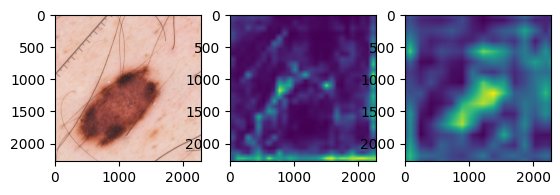

La prediccion es:  tf.Tensor([0.], shape=(1,), dtype=float32)
en realidad es:  tf.Tensor(0, shape=(), dtype=int32)


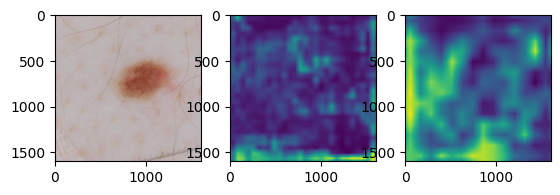

La prediccion es:  tf.Tensor([0.], shape=(1,), dtype=float32)
en realidad es:  tf.Tensor(0, shape=(), dtype=int32)


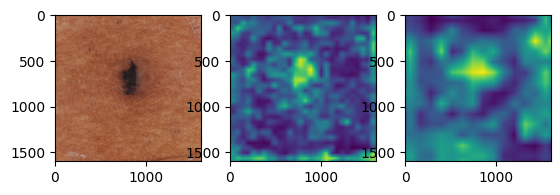

La prediccion es:  tf.Tensor([0.], shape=(1,), dtype=float32)
en realidad es:  tf.Tensor(0, shape=(), dtype=int32)


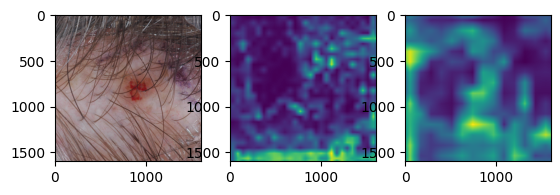

La prediccion es:  tf.Tensor([0.], shape=(1,), dtype=float32)
en realidad es:  tf.Tensor(0, shape=(), dtype=int32)


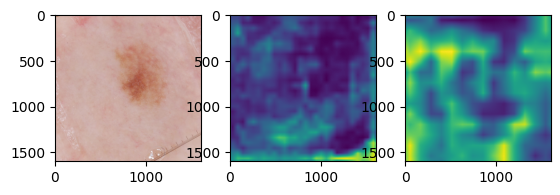

La prediccion es:  tf.Tensor([0.], shape=(1,), dtype=float32)
en realidad es:  tf.Tensor(0, shape=(), dtype=int32)


In [17]:
#obtencion MAP
output_layer_ = trained_model.get_layer(name = "dense").output
attention = trained_model.get_layer(name = "MAP1_sigmoid").output
attention_ = trained_model.get_layer(name = "MAP2_sigmoid").output
Attention_extraction_model1 = Model(inputs=trained_model.input, outputs=[attention, attention_,output_layer_])

Attention_extraction_model1.load_weights('weights/Adam/Focal_loss/definitivos.h5', by_name=True)

test_generator.reset()
_prediction=Attention_extraction_model1.predict_generator(test_generator,steps=STEP_SIZE_TEST,
verbose=1)

MAP_1 =  _prediction[0]
MAP_2 = _prediction[1]
predictions = _prediction[2]

x_test=test_generator.filepaths
for i in range(5):
  figure = plt.figure()
  figure.add_subplot(1,3,1)
  image_ = cv2.imread(x_test[i])
  image = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
  plt.imshow(image, cmap='gray')
  figure.add_subplot(1,3,2)
  plt.imshow(preprocessing_image.array_to_img(st.resize(np.array(MAP_1[i]),(image_.shape[0],image_.shape[1],1))))
  figure.add_subplot(1,3,3)
  plt.imshow(preprocessing_image.array_to_img(st.resize(np.array(MAP_2[i]),(image_.shape[0],image_.shape[1],1))))
  plt.show()
  print("La prediccion es: ", K.round(predictions[i]))
  print("en realidad es: ", K.round(test_generator.labels[i]))


# ANALISIS 

---

PARTE 1 - **ESTRUCTURAS**



In [ ]:
import json

#FUNCIONES

#Decodifica la mascara de superpixeles
def decodeSuperpixelIndex(rgbValue):
    return (rgbValue[..., 0].astype(np.uint64)) + (rgbValue[..., 1].astype(np.uint64) << np.uint64(8)) + (rgbValue[..., 2].astype(np.uint64) << np.uint64(16))

#Genera la/las mascara/s de estructura/s de una imagen 
def getStructureMasksFromImage(imageName):
  test_path = dataset_path + 'test' + os.sep
  superpixel_path = test_path +  'ISIC-2017_Test_v2_Data' + os.sep + imageName + "_superpixels.png"
  json_path = json_dirname + os.sep + 'test' + os.sep + 'ISIC-2017_Test_v2_Part2_GroundTruth' + os.sep + imageName + "_features.json"
  output_base_path = os.path.join(os.getcwd(),'imagenes_y_etiquetas/superpixels/test')

  print(json_path)

  json = readJson(json_path)
  superpixel_mask_img = preprocessing_image.load_img(superpixel_path)
  superpixel_mask_array = preprocessing_image.img_to_array(superpixel_mask_img)
  createDir(output_base_path + os.sep + imageName)
  keys = getKeysFormJson(json)
  complete_mask = np.zeros(crop(superpixel_mask_array).shape)
  for key in keys:
    structure = key
    superpixel_mask_decoded = np.zeros(superpixel_mask_array.shape)
    for y in range(superpixel_mask_array.shape[0]):
      for x in range(superpixel_mask_array.shape[1]):
        pixel = decodeSuperpixelIndex(superpixel_mask_array[y,x,:])
        superpixel_mask_decoded[y,x,:]=pixel

    structure_mask = getOneStructureMask(json,structure,superpixel_mask_decoded)
    output_superpixel_mask_path = output_base_path + os.sep + imageName + os.sep + imageName + "_" + structure + ".png"
    preprocessing_image.save_img(output_superpixel_mask_path, structure_mask)
    complete_mask = get_mask_completed(key,structure_mask,complete_mask)

  percentage_structure = getPercentageStructures(complete_mask)
  output_superpixel_complete_mask_path = output_base_path + os.sep + imageName + os.sep + imageName  + ".png"
  preprocessing_image.save_img(output_superpixel_complete_mask_path, complete_mask)
  return percentage_structure

#Genera la mascara de una estructura 
def getOneStructureMask(json, key, superpixel_mask_decoded_aux):
  data = getDataFromKey(json, key)
  for j in range(len(data)): 
    value = 0
    if(np.array(data)[j] == 1):
      value = 1
    superpixel_mask_decoded_aux[superpixel_mask_decoded_aux==j] = value
  return crop(superpixel_mask_decoded_aux)

#Genera la máscara conjunta de todas las estructuras
def get_mask_completed(structure, structure_mask,complete_mask):
  structures= ["pigment_network","negative_network","milia_like_cyst","streaks"]
  complete_mask[structure_mask==1] = (structures.index(structure)+1)/4
  return complete_mask

#Obtiene los porcentajes de cada estructura sobre la imagen completa
def getPercentageStructures(complete_mask):
  percentages_structures = []
  structures= ["skin","pigment_network","negative_network","milia_like_cyst","streaks"]
  structures_values = [0,0.25,0.5,0.75,1]

  for i in range(len(structures)):
    structure_pixels=np.where(complete_mask==structures_values[i], 1., 0.)
    percentage = (np.sum(structure_pixels)/(complete_mask.shape[0]*complete_mask.shape[1]*complete_mask.shape[2]))*100
    percentages_structures.append(percentage)
  print("porcentages: ", percentages_structures)
  return percentages_structures

#Crea un directorio
def createDir(dirPath):
  if not os.path.exists(dirPath):
    os.makedirs(dirPath)

#Lee un archivo .json
def readJson(jsonFile_path):
  with open(jsonFile_path, 'r') as fi:
    data = json.load(fi)
  return data

#Obtiene las claves de un archivo json
def getKeysFormJson(jsonFile):
  return jsonFile.keys()

#Obtiene el array de datos perteneciente a una clave de un .json
def getDataFromKey(data,key):
  return data[key]

# EXPORTAR A EXCEL LA INFORMACION SOBRE % DE PIXELES DE CADA ESTRUCTURA EN CADA IMAGEN
from openpyxl import load_workbook

def saveDataExcel(i,image_names,melanoma,s0,s1,s2,s3,s4):
  data = {'image': image_names,'melanoma': melanoma,'skin': s0,'pigment_network': s1,'negative_network': s2,'milia_like_cyst': s3,'streaks': s4}
  df = pd.DataFrame(data, columns = ['image', 'melanoma', 'skin', 'pigment_network', 'negative_network','milia_like_cyst','streaks'])
  path = 'imagenes_y_etiquetas/superpixels/test/structures%s.xlsx' % (i)
  excel_path = os.path.join(os.getcwd(),path)
  df.to_excel(excel_path)


0
a-nevus/ISIC_0016036
/content/drive/My Drive/TFG/imagenes_y_etiquetas/part_2/test/ISIC-2017_Test_v2_Part2_GroundTruth/ISIC_0016036_features.json


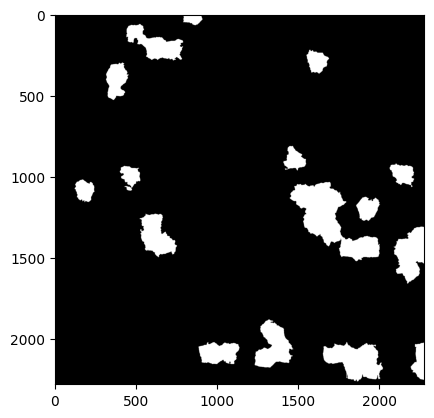

porcentages:  [90.98401629203566, 9.015983707964335, 0.0, 0.0, 0.0]
['ISIC_0016036']
[1]
[90.98401629203566]
[9.015983707964335]
[0.0]
[0.0]
[0.0]
0
image_names ['a-nevus/ISIC_0016036']
melanoma [1]
s0 [90.98401629203566]
s1 [9.015983707964335]
s2 [0.0]
s3 [0.0]
s4 [0.0]


In [ ]:
image_names = test_generator.filenames
s0 = []
s1 = []
s2 = []
s3 = []
s4 = []
images = []
melanoma = []

for i in range(len(image_names)):
  print(i)
  image = image_names[i]
  print(image)
  pos = image_names.index(image)
  porcentages = getStructureMasksFromImage(image.split("/")[1].split(".")[0])
  if(test_generator.labels[::-1][pos]==1):
    melanoma.append(1)
  else: 
    melanoma.append(0)
  images.append(image.split("/")[1].split(".")[0])
  s0.append(porcentages[0])
  s1.append(porcentages[1])
  s2.append(porcentages[2])
  s3.append(porcentages[3])
  s4.append(porcentages[4])
  print(images)
  print(melanoma)
  print(s0)
  print(s1)
  print(s2)
  print(s3)
  print(s4)

  if(i%10==0):
    if(i==0):
      print("0")
    else:
      #saveDataExcel(i,images,melanoma,s0,s1,s2,s3,s4)
      s0 = []
      s1 = []
      s2 = []
      s3 = []
      s4 = []
      images = []
      melanoma = []

print("image_names",image_names)
print("melanoma",melanoma)
print("s0",s0)
print("s1",s1)
print("s2",s2)
print("s3",s3)
print("s4",s4)

image 0: a-nevus/ISIC_0016036


TypeError: ignored

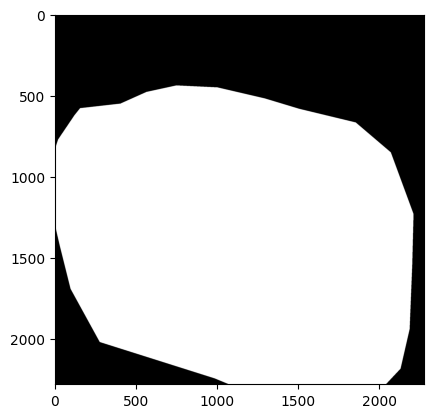

In [ ]:
#Mascara de estructuras incluyendo la lesion
def invertir(array):
  return abs(array-1)

def saveLesionMasc(masc, imageName, masc_structure_path):
  path = masc_structure_path + imageName + os.sep + imageName + "_lesion" + ".png"
  print(path)
  preprocessing_image.save_img(path, masc)
  return
def saveExcel(lesion, skin):
  data = {'lesion': lesion,'skin': skin}
  df = pd.DataFrame(data, columns = ['lesion', 'skin'])
  path = 'imagenes_y_etiquetas/superpixels/structures_test_lesion%s.xlsx' % (i)
  excel_path = os.path.join(os.getcwd(),path)
  df.to_excel(excel_path)
  return

def getLesionPorcentaje(imageName):
  test_path = os.path.join(os.getcwd(),'imagenes_y_etiquetas/part 1/test/')
  masc_path = test_path +  "ISIC-2017_Test_v2_Part1_GroundTruth" + os.sep + imageName + "_segmentation.png"
  masc_structure_path = os.path.join(os.getcwd(),'imagenes_y_etiquetas/superpixels/test/')

  masc = crop(preprocessing_image.img_to_array(preprocessing_image.load_img(masc_path)))
  plt.imshow(preprocessing_image.array_to_img(masc))
  plt.imshow()
  structures = ["pigment_network","negative_network","milia_like_cyst","streaks"]

  for structure in structures:
    masc_structure = preprocessing_image.img_to_array(preprocessing_image.load_img(masc_structure_path + imageName + os.sep + imageName + "_" + structure + ".png"))/255
    masc[masc_structure == 1] = 0
    masc_structure = []
  saveLesionMasc(masc, imageName, masc_structure_path)

  porcentaje_lesion = (np.sum(masc/255)/(masc.shape[0] * masc.shape[1] * masc.shape[2]))*100
  porcentaje_skin = (np.sum(invertir(masc/255))/(masc.shape[0] * masc.shape[1] * masc.shape[2]))*100

  return porcentaje_lesion, porcentaje_skin

test_gener = test_generator
image_names = ["a-nevus/ISIC_0016036"]
lesion = []
skin = [] 

for image_name in image_names:
  i = image_names.index(image_name)
  print("image %s: %s" %(i,image_name))
  p_lesion, p_skin = getLesionPorcentaje(image_name.split("/")[1].split(".")[0])
  print(p_lesion)
  print(p_skin)
  lesion.append(p_lesion)
  skin.append(p_skin)

  if((i%len(image_names)==0)):
    saveExcel(lesion, skin)
    lesion = []
    skin = []


In [ ]:
## Obtener la mascara totla con todas las estructuras incluida la lesion
def changestructurecomplete(image_name):
  structures= ["lesion","pigment_network","negative_network","milia_like_cyst","streaks"]
  path = os.path.join(os.getcwd(),'imagenes_y_etiquetas/superpixels/test')
  img_masc_path = path + os.sep + image_name + os.sep + image_name + ".png"
  img_masc = preprocessing_image.img_to_array(preprocessing_image.load_img(img_masc_path))

  complete_mask = np.zeros(img_masc.shape)
  for structure in structures:
    img_structure_masc_path = path + os.sep + image_name + os.sep + image_name + "_" + structure + ".png"
    img_structure_masc = preprocessing_image.img_to_array(preprocessing_image.load_img(img_structure_masc_path))
    complete_mask[img_structure_masc==255] = (structures.index(structure)+1)/5
  preprocessing_image.save_img(img_masc_path, complete_mask)

for image_name in image_names:
  name = image_name.split("/")[1].split(".")[0]
  changestructurecomplete(name)


116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365



PARTE 2 - **ATENCION** ¿A que estructuras atiende más la red?




In [ ]:
#FUNCIONES

#Recupera la mascara de estructuras correspondiente a una imagen y una estructura 
def getStructureMask(image_name, structure):
  path = os.path.join(os.getcwd(),'imagenes_y_etiquetas/superpixels/test')
  if(structure == "skin"):
    structure_mask_path = path + os.sep + image_name + os.sep + image_name + ".png"
  else:
    structure_mask_path = path + os.sep + image_name + os.sep + image_name + "_" + structure + ".png"
  structure_mask = preprocessing_image.load_img(structure_mask_path)
  structure_mask_array = preprocessing_image.img_to_array(structure_mask)
  return structure_mask_array

#Redimensiona el mapa de atención espacial
def getResizedMap(attn_map, shape):
  map_resized= st.resize(attn_map, shape)
  plt.imshow(map_resized)
  plt.show()
  return st.resize(attn_map, shape)

#Calcula las probabilidades de atención dada una estructura
def getPorcentajeStructure(image_name, structure, mask, MAP):
  # Calculo p_att (atención)
  p_att = np.sum(MAP) / np.size(MAP) # Promedio de atención, a nivel de píxel.
  p_non_att=np.sum(1-MAP) / np.size(1-MAP)

  # Calculo p_si_given_att (condicional estructura dada atención)
  if(np.sum(MAP)==0):
    MAP_normalized = np.zeros(MAP.shape)
  else:
    MAP_normalized = MAP / np.sum(MAP) 
  p_si = np.sum(mask==1) / np.size(mask)
  p_si_given_att = np.sum(np.multiply(((MAP)/np.sum(MAP)), (mask==1)))
  p_si_given_non_att = np.sum(np.multiply(((1-MAP)/np.sum(1-MAP)),(mask==1)))

  # Calculo p_si (estructura)
  p_si = np.sum(mask) / np.size(mask)

  # Finalmente, calculo p_att_given_si
  p_attn_given_si =(p_si_given_att*p_att)/(p_si + np.finfo(float).eps)
  p_non_att_given_si= (p_si_given_non_att*p_non_att)/(p_si+np.finfo(float).eps)
  return p_attn_given_si

def saveDataExcel(map,i,image_names,melanoma,s0,s1,s2,s3,s4,lesion):
  data = {'image': image_names,'melanoma': melanoma,'skin': s0,'lesion':lesion, 'pigment_network': s1,'negative_network': s2,'milia_like_cyst': s3,'streaks': s4}
  df = pd.DataFrame(data, columns = ['image', 'melanoma', 'skin', 'lesion','pigment_network', 'negative_network','milia_like_cyst','streaks'])
  path = 'imagenes_y_etiquetas/attention/test/attention_ttest_%s_%s.xlsx' % (map, i)
  excel_path = os.path.join(os.getcwd(),path)
  df.to_excel(excel_path)

def vaciarArrays():
  imag_names = []
  melanoma = []
  S0_1 = []
  S0_2 = []
  S1_1 = []
  S1_2 = []
  S2_1 = []
  S2_2 = []
  S3_1 = []
  S3_2 = []
  S4_1 = []
  S4_2 = []
  lesion_1=[]
  lesion_2=[]
  return imag_names,melanoma,S0_1,S0_2,S1_1,S1_2,S2_1,S2_2,S3_1,S3_2,S4_1,S4_2, lesion_1,lesion_2

def getAttn(label,name, attn_map_1, attn_map_2, structures):
  attn_2_porcentajes=[]
  attn_1_porcentajes=[]
  for structure in structures:
    print("---- %s ----" % (structure))
    mask = getStructureMask(name,structure)
    if(structure == "skin"):
      mask = np.where(mask==0, 1,0)
    
    if(np.sum(mask)!= 0):
      mask = mask / np.max(mask)
    shape = mask.shape
    MAP_1_resized =  getResizedMap(attn_map_1,shape)
    MAP_2_resized=  getResizedMap(attn_map_2,shape)
    porcentaje_1 = getPorcentajeStructure(name, structure, mask,MAP_1_resized)
    attn_1_porcentajes.append(porcentaje_1)
    porcentaje_2 = getPorcentajeStructure(name, structure, mask,MAP_2_resized)
    attn_2_porcentajes.append(porcentaje_2)
  
  return attn_1_porcentajes, attn_2_porcentajes


412 -> b-melanoma/ISIC_0012758.jpg
prediccion:  [0.24033393]
---- skin ----


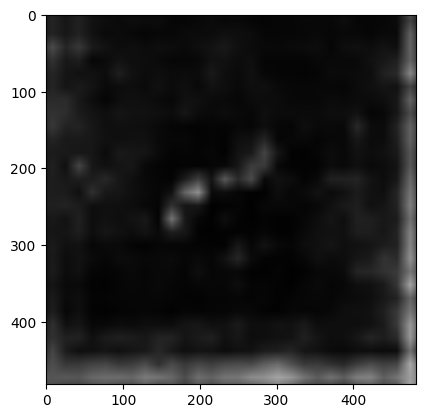

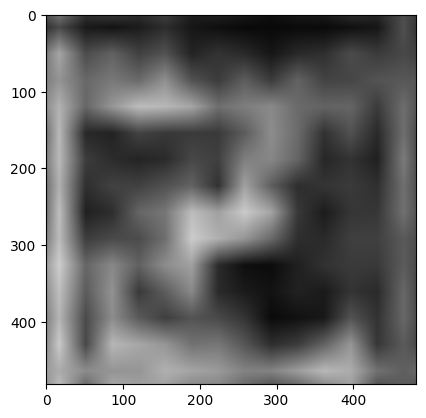

---- lesion ----


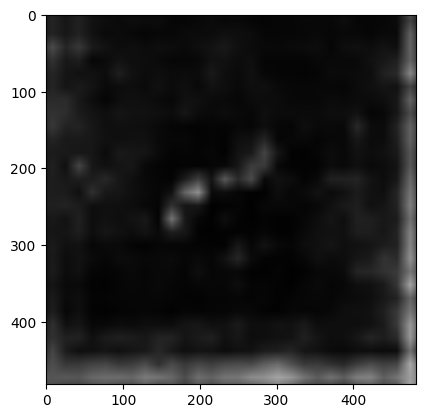

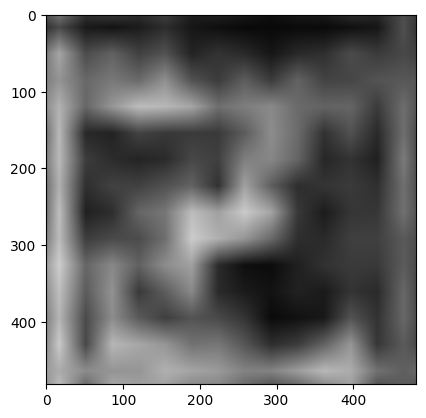

---- pigment_network ----


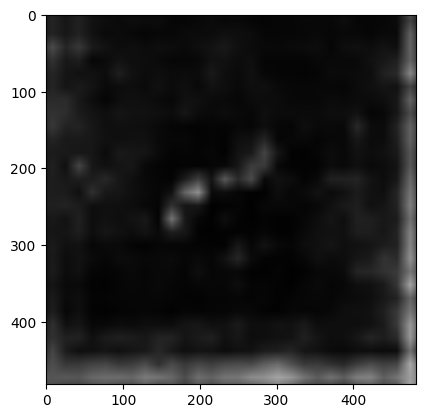

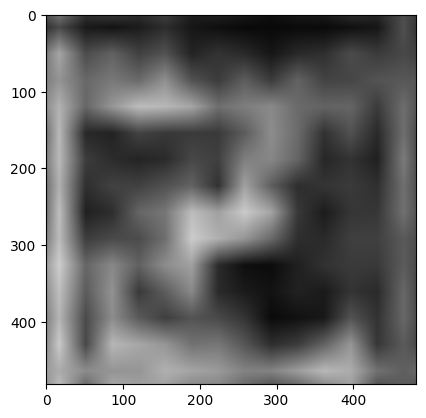

---- negative_network ----


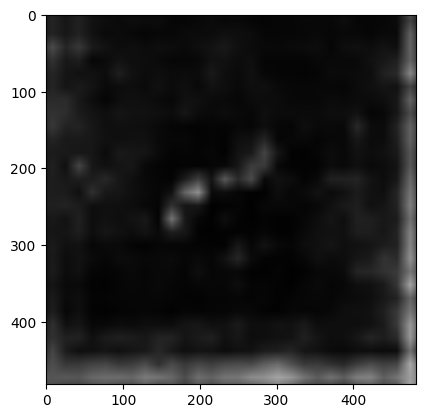

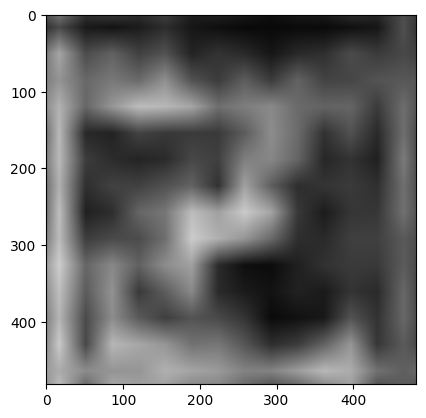

---- milia_like_cyst ----


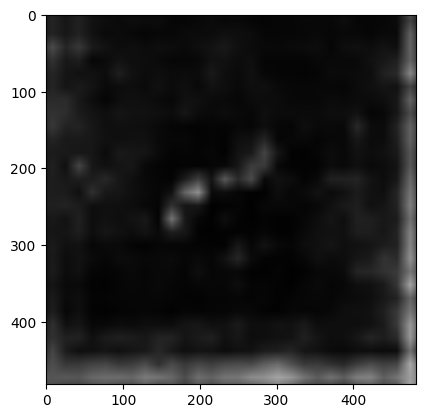

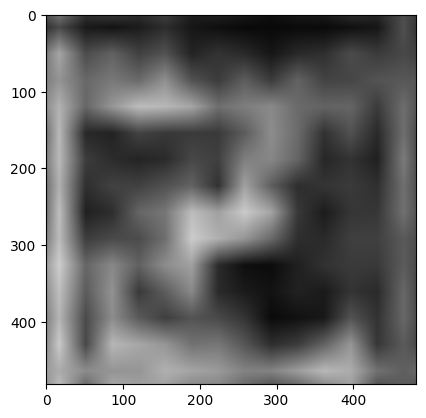

---- streaks ----


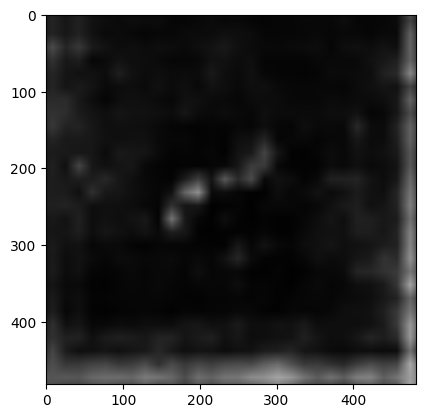

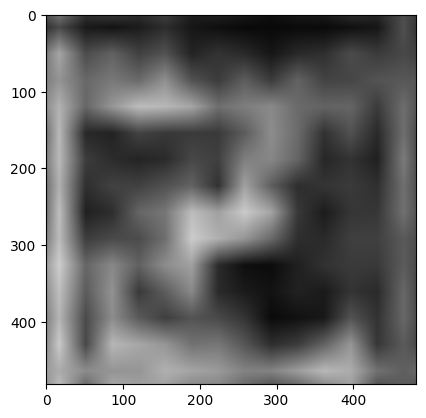

porcentajes attn_1: [0.0983600800948932, 0.06827882602122075, 0.07761792500778553, 0.0, 0.0, 0.09859098974246402]
porcentajes attn_2: [0.3354551484049439, 0.4739632593977775, 0.5227318349759582, 0.0, 0.0, 0.3316638673310932]


In [ ]:


image_labels =[]
image_names = []
train_generator_ = test_generator
image_names = train_generator_.filenames
image_labels = train_generator_.labels
structures = ["skin", "lesion", "pigment_network","negative_network","milia_like_cyst","streaks"]
attn_2_porcentajes = []
attn_1_porcentajes = []
imag_names,melanoma,S0_1,S0_2,S1_1,S1_2,S2_1,S2_2,S3_1,S3_2,S4_1,S4_2, lesion_1,lesion_2 = vaciarArrays()

for image_name in image_names_:
  i=image_names.index(image_name)
  name = image_names[i].split("/")[1].split(".")[0]
  label = image_labels[i]
  attn_map_1 = MAP_1[i,:,:,:]
  attn_map_2 = MAP_2[i,:,:,:]
  attn_1_porcentajes, attn_2_porcentajes = getAttn(label,name, attn_map_1, attn_map_2, structures)
  imag_names.append(name)
  melanoma.append(label)

  S0_1.append(attn_1_porcentajes[0])
  lesion_1.append(attn_1_porcentajes[1])
  S1_1.append(attn_1_porcentajes[2])
  S2_1.append(attn_1_porcentajes[3])
  S3_1.append(attn_1_porcentajes[4])
  S4_1.append(attn_1_porcentajes[5])
  S0_2.append(attn_2_porcentajes[0])
  lesion_2.append(attn_2_porcentajes[1])
  S1_2.append(attn_2_porcentajes[2])
  S2_2.append(attn_2_porcentajes[3])
  S3_2.append(attn_2_porcentajes[4])
  S4_2.append(attn_2_porcentajes[5])

  saveDataExcel("map-1",i,imag_names,melanoma,S0_1,S1_1,S2_1,S3_1,S4_1,lesion_1)
  saveDataExcel("map-2",i,imag_names,melanoma,S0_2,S1_2,S2_2,S3_2,S4_2, lesion_2)
